In [1]:
#import torch
import os, sys, re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

3412955


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [5]:
ls 

20230513-Segmentation.ipynb  20230818-Segmentation.ipynb
20230622-Segmentation.ipynb


In [6]:
# data_folder
data_folder = r'/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune'
# correction
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20230824-Merscope01'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

In [7]:
# transpose with microscope
parameter_folder = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters'
microscope_file = os.path.join(parameter_folder, 'microscope', 'merscope01_microscope.json')
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.107,
 'image_dimensions': [2304, 2304]}

In [8]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage.csv')
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune
-- 9 folders, 255 fovs detected.
- load color_usage from file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Analysis/color_usage.csv


In [9]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '637', 'hyb': 'H8M9'} 477


# Run segmentation

In [20]:
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d

In [14]:
from importlib import reload

In [19]:
import ChromAn
reload(ChromAn.src.file_io.dax_process)

<module 'ChromAn.src.file_io.dax_process' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/file_io/dax_process.py'>

In [40]:
for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    #_ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls.ref_correction_channel = '637'
    #_cls._corr_illumination()
    _cls._calculate_drift(_ref_im, )
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        #batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=50, 
                                        min_size=2000,
                                        do_3D=False,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )

reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_000.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_000.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_000_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 0.618s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_000_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single im

- Loaded images for channels:['637', '477'] in 3.387s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   2.84 0.21] in 0.848s.
-- drift 1: [0.   3.04 0.43] in 0.691s.
-- drift 2: [-0.04  3.37 -0.26] in 0.704s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 9.993s.
- Finished warp correction in 9.993s.
- apply microscope corrections
- run Cellpose segmentation - save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_4.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_005.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainI

- run Cellpose segmentation in 184.042s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_8.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_009.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_009.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_009.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_009_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.498s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_009.dax
- New save file: /la

- Loaded images for channels:['477', '405'] in 4.405s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_013.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_013_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.319s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.23  0.    0.01] in 0.895s.
-- drift 1: [-0.02  0.   -0.02] in 0.990s.
-- drift 2: [-0.38  0.02 -0.04] in 0.742s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 10.651s.
- Finished warp correction 

-- corrected warp for channel 637 in 9.899s.
- Finished warp correction in 9.899s.
- apply microscope corrections
- run Cellpose segmentation in 177.974s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_17.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_018.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_018.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_018.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_018_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.532s.
Initialize DaxProcesser for file:/lab/weis

- Loaded images for channels:['477', '405'] in 4.519s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_022.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_022_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.074s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.04 1.05 1.39] in 0.761s.
-- drift 1: [-0.01  0.01  0.03] in 0.698s.
-- drift 2: [-0.06  2.78 -1.26] in 0.707s.
-- drift 3: [ 0.09  0.   -0.02] in 0.673s.
-- drift 4: [-0.04  2.31 -1.52] in 0.678s.
-- drift 5: [ 0.12 -0.01  0.02] in 0.735s.
-- drift 6: [0.   0.02 0.06] in 0.668s.
--- drifts for crops:[1 3 5 6] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3

- Loaded images for channels:['637', '477'] in 3.583s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.03  2.93 -2.  ] in 0.855s.
-- drift 1: [-0.03  2.15 -1.87] in 0.867s.
-- drift 2: [-0.03  2.25 -0.4 ] in 0.652s.
-- drift 3: [-0.05  2.63 -1.95] in 0.643s.
--- drifts for crops:[0 1 3] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 10.001s.
- Finished warp correction in 10.002s.
- apply microscope corrections
- run Cellpose segmentation in 173.800s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_26.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_027.dax
PolyT and DAPI image: /lab/weis

- run Cellpose segmentation in 177.552s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_30.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_031.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_031.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_031.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_031_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.417s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_031.dax
- New save file: /l

- Loaded images for channels:['477', '405'] in 4.690s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_035.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_035_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.765s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.3  -0.02  0.  ] in 0.858s.
-- drift 1: [-0.03  3.44  0.44] in 0.855s.
-- drift 2: [ 0.12 -0.78  4.45] in 0.696s.
-- drift 3: [-0.24 -0.01  0.  ] in 0.700s.
-- drift 4: [0.21 0.1  0.06] in 0.698s.
-- drift 5: [-0.02  0.01  0.  ] in 0.697s.
--- drifts for crops:[0 3 4 5] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- load

- Loaded images for channels:['637', '477'] in 4.034s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    1.99 -2.58] in 0.740s.
-- drift 1: [-0.02  1.92 -2.21] in 0.689s.
-- drift 2: [ 0.    1.9  -3.27] in 0.686s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 18.399s.
- Finished warp correction in 18.400s.
- apply microscope corrections
- run Cellpose segmentation in 192.866s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_39.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_040.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw01

- Loaded images for channels:['477', '405'] in 4.985s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_044.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_044_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 4.951s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.36  0.05 -0.02] in 0.889s.
-- drift 1: [-0.06  2.25 -1.32] in 0.870s.
-- drift 2: [-0.03  2.34 -1.16] in 0.683s.
-- drift 3: [-0.28  0.02 -0.04] in 0.681s.
-- drift 4: [-0.02  2.52 -0.75] in 0.686s.
-- drift 5: [-0.06  1.89 -1.1 ] in 0.681s.
--- drifts for crops:[1 2 5] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loa

-- drift 2: [-0.02  2.95 -1.72] in 0.864s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 10.676s.
- Finished warp correction in 10.677s.
- apply microscope corrections
- run Cellpose segmentation in 190.317s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_48.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_049.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_049.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_049.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230

- Loaded images for channels:['477', '405'] in 4.080s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_053.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_053_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.673s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.04  2.78 -0.04] in 0.829s.
-- drift 1: [ 0.01  3.13 -0.34] in 0.650s.
-- drift 2: [ 0.17 -0.02  0.01] in 0.655s.
-- drift 3: [-0.03  2.64 -0.28] in 0.844s.
-- drift 4: [-0.04  2.81  0.12] in 0.833s.
--- drifts for crops:[0 1 3 4] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from fi

-- drift 0: [-0.04  2.92 -1.85] in 0.861s.
-- drift 1: [-0.04  2.13 -0.97] in 1.001s.
-- drift 2: [-0.03  3.63 -0.24] in 0.755s.
-- drift 3: [-0.04  1.99 -0.07] in 0.702s.
-- drift 4: [ 0.    3.02 -1.9 ] in 0.699s.
--- drifts for crops:[0 1 4] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 15.071s.
- Finished warp correction in 15.072s.
- apply microscope corrections
- run Cellpose segmentation in 185.718s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_57.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_058.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_058.dax
Initialize DaxProcesser f

- run Cellpose segmentation in 187.926s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_61.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_062.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_062.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_062.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_062_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.621s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_062.dax
- New save file: /l

- Loaded images for channels:['477', '405'] in 4.439s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_066.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_066_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 4.082s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  2.71 -1.32] in 0.852s.
-- drift 1: [-0.03  2.77  0.17] in 0.685s.
-- drift 2: [-0.01  3.   -1.37] in 0.686s.
-- drift 3: [-0.04  2.33 -1.09] in 0.695s.
--- drifts for crops:[0 2 3] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 

-- drift 2: [ 0.    2.73 -0.93] in 0.694s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 15.364s.
- Finished warp correction in 15.364s.
- apply microscope corrections
- run Cellpose segmentation in 196.735s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_70.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_071.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_071.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_071.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230

- Loaded images for channels:['477', '405'] in 4.025s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_079.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_079_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.799s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    0.96 -2.81] in 0.711s.
-- drift 1: [0.01 0.6  0.03] in 0.939s.
-- drift 2: [-0.01  1.28 -3.79] in 0.777s.
-- drift 3: [-0.02  1.65 -1.35] in 0.700s.
-- drift 4: [0.02 2.13 2.37] in 0.692s.
-- drift 5: [-0.03  1.12  1.06] in 0.698s.
-- drift 6: [0.05 2.14 0.27] in 0.694s.
-- drift 7: [-0.08  0.01 -0.01] in 0.699s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:['637']
-

-- drift 1: [-0.02  3.13  0.15] in 0.699s.
-- drift 2: [-0.05  3.11 -0.11] in 0.701s.
-- drift 3: [-0.03  3.45  0.76] in 0.878s.
-- drift 4: [ 0.01  4.1  -1.8 ] in 0.704s.
-- drift 5: [-0.01  3.09  0.43] in 0.698s.
-- drift 6: [-0.02  0.5   0.26] in 0.708s.
--- drifts for crops:[1 2 5] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 12.905s.
- Finished warp correction in 12.905s.
- apply microscope corrections
- run Cellpose segmentation in 190.601s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_83.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_084.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/C

- run Cellpose segmentation in 194.074s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_87.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_088.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_088.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_088.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_088_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.965s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_088.dax
- New save file: /l

- Loaded images for channels:['477', '405'] in 4.459s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_092.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_092_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.206s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   3.33 0.89] in 0.821s.
-- drift 1: [-0.02  2.18  0.13] in 0.700s.
-- drift 2: [0.   1.92 0.93] in 0.671s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 9.848s.
- Finished warp correction in 9.84

-- corrected warp for channel 637 in 13.328s.
- Finished warp correction in 13.329s.
- apply microscope corrections
- run Cellpose segmentation in 189.754s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_96.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_097.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_097.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_097.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_097_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 3.849s.
Initialize DaxProcesser for file:/lab/we

- Loaded images for channels:['477', '405'] in 4.656s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_101.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_101_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.227s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   0.31 0.39] in 0.865s.
-- drift 1: [-0.02  1.12  0.96] in 0.695s.
-- drift 2: [-0.04  1.29  0.79] in 0.700s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 15.000s.
- Finished warp correction in 

-- corrected warp for channel 637 in 16.397s.
- Finished warp correction in 16.397s.
- apply microscope corrections
- run Cellpose segmentation in 189.708s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_105.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_106.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_106.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_106.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_106_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 3.976s.
Initialize DaxProcesser for file:/lab/w

- Loaded images for channels:['477', '405'] in 3.984s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_110.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_110_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.876s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.03  2.81 -0.52] in 0.837s.
-- drift 1: [-0.02  2.68 -0.28] in 0.695s.
-- drift 2: [-0.04  2.3  -0.61] in 0.702s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 16.891s.
- Finished warp correction 

-- corrected warp for channel 637 in 10.115s.
- Finished warp correction in 10.115s.
- apply microscope corrections
- run Cellpose segmentation - save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_114.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_115.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_115.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_115.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_115_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.309s.
Initialize DaxProcesser for file:/lab/weissman_imagi

- Loaded images for channels:['477', '405'] in 3.841s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_119.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_119_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.514s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01  2.15 -0.55] in 0.879s.
-- drift 1: [-0.03  2.01 -0.15] in 0.719s.
-- drift 2: [ 0.    2.06 -0.4 ] in 0.720s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 10.517s.
- Finished warp correction 

-- corrected warp for channel 637 in 10.778s.
- Finished warp correction in 10.778s.
- apply microscope corrections
- run Cellpose segmentation - save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_123.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_124.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_124.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_124.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_124_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.774s.
Initialize DaxProcesser for file:/lab/weissman_imagi

- Loaded images for channels:['477', '405'] in 4.059s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_128.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_128_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.725s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  2.23 -1.48] in 0.857s.
-- drift 1: [-0.03  2.18 -1.3 ] in 0.685s.
-- drift 2: [-0.02  1.94 -1.43] in 0.687s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 13.863s.
- Finished warp correction 

-- drift 1: [-0.03  2.79  0.8 ] in 0.673s.
-- drift 2: [-0.02  2.1   0.66] in 0.685s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 15.692s.
- Finished warp correction in 15.693s.
- apply microscope corrections
- run Cellpose segmentation in 189.268s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_132.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_133.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_133.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_133.dax
- New save file:

- Loaded images for channels:['477', '405'] in 4.764s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_137.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_137_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.721s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  1.93  0.13] in 0.848s.
-- drift 1: [-0.02  2.18  0.27] in 0.684s.
-- drift 2: [0.   1.56 0.58] in 0.696s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 13.370s.
- Finished warp correction in 

-- corrected warp for channel 637 in 11.608s.
- Finished warp correction in 11.608s.
- apply microscope corrections
- run Cellpose segmentation in 188.795s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_141.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_142.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_142.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_142.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_142_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.844s.
Initialize DaxProcesser for file:/lab/w

- Loaded images for channels:['477', '405'] in 4.827s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_146.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_146_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 4.339s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  1.93 -2.37] in 0.849s.
-- drift 1: [-0.03  2.22 -1.84] in 0.678s.
-- drift 2: [-0.01  1.96 -1.55] in 0.686s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 13.444s.
- Finished warp correction 

-- corrected warp for channel 637 in 13.865s.
- Finished warp correction in 13.865s.
- apply microscope corrections
- run Cellpose segmentation - save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_150.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_151.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_151.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_151.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_151_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 5.064s.
Initialize DaxProcesser for file:/lab/weissman_imagi

- Loaded images for channels:['477', '405'] in 4.464s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_155.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_155_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.583s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.03  3.11 -0.34] in 0.842s.
-- drift 1: [-0.04  2.94 -0.51] in 0.687s.
-- drift 2: [-0.02  2.91 -0.4 ] in 0.696s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 15.108s.
- Finished warp correction 

-- corrected warp for channel 637 in 12.717s.
- Finished warp correction in 12.718s.
- apply microscope corrections
- run Cellpose segmentation in 188.948s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_159.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_160.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_160.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_160.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_160_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.549s.
Initialize DaxProcesser for file:/lab/w

- Loaded images for channels:['477', '405'] in 5.087s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_164.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_164_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.665s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   3.8  1.23] in 0.843s.
-- drift 1: [0.01 1.71 0.47] in 0.679s.
-- drift 2: [-0.02  2.72  2.26] in 0.687s.
-- drift 3: [-0.01  1.81 -1.32] in 0.679s.
-- drift 4: [-0.02  2.02  0.26] in 0.736s.
-- drift 5: [-0.01  2.01  0.06] in 0.684s.
--- drifts for crops:[1 4 5] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading c

-- corrected warp for channel 637 in 14.106s.
- Finished warp correction in 14.106s.
- apply microscope corrections
- run Cellpose segmentation in 193.684s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_168.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_169.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_169.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_169.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_169_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.489s.
Initialize DaxProcesser for file:/lab/w

- Loaded images for channels:['477', '405'] in 4.870s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_173.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_173_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.822s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.08  1.22 -1.87] in 0.794s.
-- drift 1: [ 0.03  1.84 -2.86] in 0.678s.
-- drift 2: [-0.02  1.43 -1.83] in 0.678s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 13.655s.
- Finished warp correction 

-- corrected warp for channel 637 in 16.686s.
- Finished warp correction in 16.686s.
- apply microscope corrections
- run Cellpose segmentation in 194.717s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_177.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_178.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_178.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_178.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_178_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.315s.
Initialize DaxProcesser for file:/lab/w

- Loaded images for channels:['477', '405'] in 4.781s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_182.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_182_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 4.297s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    0.34 -1.65] in 0.810s.
-- drift 1: [ 0.    1.39 -1.55] in 0.659s.
-- drift 2: [ 0.17 -1.24 -4.98] in 0.668s.
-- drift 3: [-0.06  0.52 -2.01] in 0.655s.
-- drift 4: [-0.02  2.63 -0.07] in 0.656s.
--- drifts for crops:[0 1 3] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file

-- corrected warp for channel 637 in 19.669s.
- Finished warp correction in 19.669s.
- apply microscope corrections
- run Cellpose segmentation in 189.749s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_186.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_187.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_187.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_187.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_187_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.444s.
Initialize DaxProcesser for file:/lab/w

- Loaded images for channels:['477', '405'] in 4.193s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_191.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_191_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.916s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.03  2.04 -1.07] in 0.846s.
-- drift 1: [ 0.    1.56 -0.91] in 0.684s.
-- drift 2: [-0.03  1.25 -0.84] in 0.684s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 17.143s.
- Finished warp correction 

-- corrected warp for channel 637 in 10.891s.
- Finished warp correction in 10.891s.
- apply microscope corrections
- run Cellpose segmentation - save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_195.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_196.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_196.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_196.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_196_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 3.996s.
Initialize DaxProcesser for file:/lab/weissman_imagi

- Loaded images for channels:['477', '405'] in 4.491s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_200.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_200_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.561s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    2.05 -2.22] in 0.842s.
-- drift 1: [0.   2.34 0.72] in 0.681s.
-- drift 2: [-0.01  2.11 -1.57] in 0.673s.
-- drift 3: [-0.04  1.14  0.83] in 0.681s.
-- drift 4: [-0.01  1.76 -2.13] in 0.672s.
-- drift 5: [ 0.01  1.77 -0.01] in 0.678s.
-- drift 6: [ 0.01  2.26 -0.11] in 0.751s.
--- drifts for crops:[2 5 6] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 

-- drift 1: [-0.02  0.98 -0.3 ] in 0.698s.
-- drift 2: [-0.03  0.66  0.2 ] in 0.704s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 15.716s.
- Finished warp correction in 15.716s.
- apply microscope corrections
- run Cellpose segmentation in 192.726s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_204.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_205.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_205.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_205.dax
- New save file:

- Loaded images for channels:['477', '405'] in 4.196s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_209.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_209_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.953s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  1.34 -2.32] in 0.836s.
-- drift 1: [-0.02  1.97 -2.26] in 0.669s.
-- drift 2: [-0.01  1.37 -1.79] in 0.673s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 9.653s.
- Finished warp correction i

-- corrected warp for channel 637 in 10.097s.
- Finished warp correction in 10.097s.
- apply microscope corrections
- run Cellpose segmentation in 187.136s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_213.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_214.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_214.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_214.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_214_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 3.791s.
Initialize DaxProcesser for file:/lab/w

- Loaded images for channels:['477', '405'] in 4.303s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_218.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_218_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.319s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.04  0.96 -1.4 ] in 0.808s.
-- drift 1: [-0.01  0.69 -1.69] in 0.683s.
-- drift 2: [-0.04  1.16 -2.08] in 0.759s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 11.670s.
- Finished warp correction 

-- corrected warp for channel 637 in 14.368s.
- Finished warp correction in 14.368s.
- apply microscope corrections
- run Cellpose segmentation - save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_222.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_223.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_223.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_223.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_223_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 4.787s.
Initialize DaxProcesser for file:/lab/weissman_imagi

- Loaded images for channels:['477', '405'] in 5.142s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_227.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_227_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 3.741s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  1.79  0.32] in 0.785s.
-- drift 1: [ 0.    1.93 -0.17] in 0.702s.
-- drift 2: [-0.01  1.36  0.02] in 0.698s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 16.582s.
- Finished warp correction 

-- corrected warp for channel 637 in 10.727s.
- Finished warp correction in 10.728s.
- apply microscope corrections
- run Cellpose segmentation in 182.176s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_231.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_232.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_232.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_232.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_232_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 10.702s.
Initialize DaxProcesser for file:/lab/

- Loaded images for channels:['477', '405'] in 9.320s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_236.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_236_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 4.430s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.03  1.51  0.83] in 0.862s.
-- drift 1: [-0.03  1.5   0.67] in 0.883s.
-- drift 2: [-0.02  0.91  1.05] in 0.887s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 11.389s.
- Finished warp correction 

-- corrected warp for channel 637 in 17.491s.
- Finished warp correction in 17.492s.
- apply microscope corrections
- run Cellpose segmentation in 189.384s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_240.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_241.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_241.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_241.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_241_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 6.150s.
Initialize DaxProcesser for file:/lab/w

- Loaded images for channels:['477', '405'] in 13.470s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_245.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_245_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 11.778s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  1.19 -0.78] in 0.909s.
-- drift 1: [0.   0.49 0.19] in 0.807s.
-- drift 2: [ 0.    0.84 -0.17] in 0.721s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D warpping for channels:['637'].
-- loading chromatic correction profile from file:
	 637 None
-- corrected warp for channel 637 in 15.327s.
- Finished warp correction i

-- corrected warp for channel 637 in 17.091s.
- Finished warp correction in 17.091s.
- apply microscope corrections
- run Cellpose segmentation in 195.683s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/Segmentation/segmentation_label_249.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_250.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_250.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_250.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H0M1/Conv_zscan_250_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 15.310s.
Initialize DaxProcesser for file:/lab/

- Loaded images for channels:['477', '405'] in 5.458s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_254.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20230816-asw016_region_1_MF1msBrainImmune/H8M9/Conv_zscan_254_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 20.960s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.   -0.29  0.73] in 0.839s.
-- drift 1: [0.01 0.69 0.72] in 0.906s.
-- drift 2: [ 0.    2.84 -2.45] in 0.824s.
-- drift 3: [0.01 0.17 0.25] in 0.673s.
-- drift 4: [ 0.06  2.02 -1.  ] in 0.680s.
-- drift 5: [-0.01  1.17  1.38] in 0.720s.
-- drift 6: [0.01 0.13 0.36] in 0.684s.
--- drifts for crops:[1 3 6] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:['637']
- Start 3D wa

In [23]:
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))

<IPython.core.display.Javascript object>


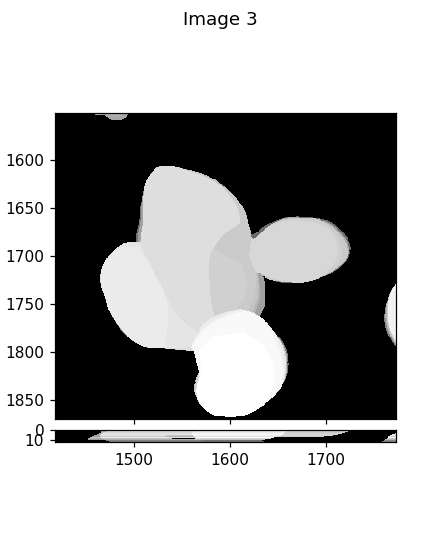

In [41]:
%matplotlib notebook
imshow_mark_3d([_dapi_im, _polyt_im, labels3d])

In [31]:
from merlin.analysis.segment import CellPoseSegment

In [37]:
%%time
combined_labels_3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

CPU times: user 17.9 s, sys: 3.19 s, total: 21.1 s
Wall time: 21.1 s


<IPython.core.display.Javascript object>


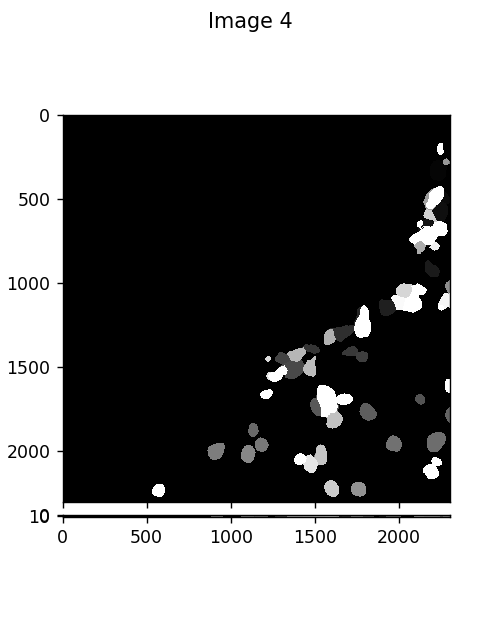

In [38]:
imshow_mark_3d([_dapi_im, _polyt_im, labels3d, combined_labels_3d])

In [ ]:
combined_labels_3d

In [15]:
_ref_cls.correction_log

{'748': {}, '637': {}, '545': {}, '477': {}, '405': {}}

- apply microscope corrections
- run Cellpose segmentation in 179.238s.


In [10]:

for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=60, 
                                        min_size=2000,
                                        do_3D=True,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = labels3d.copy() # no modification is required for this one.

        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )

Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_1.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_2.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_3.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_4.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_l

Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_107.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_108.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_109.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_110.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_111.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segm

- apply microscope corrections
- run Cellpose segmentation in 142.370s.
- save to file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_20.npy


<IPython.core.display.Javascript object>


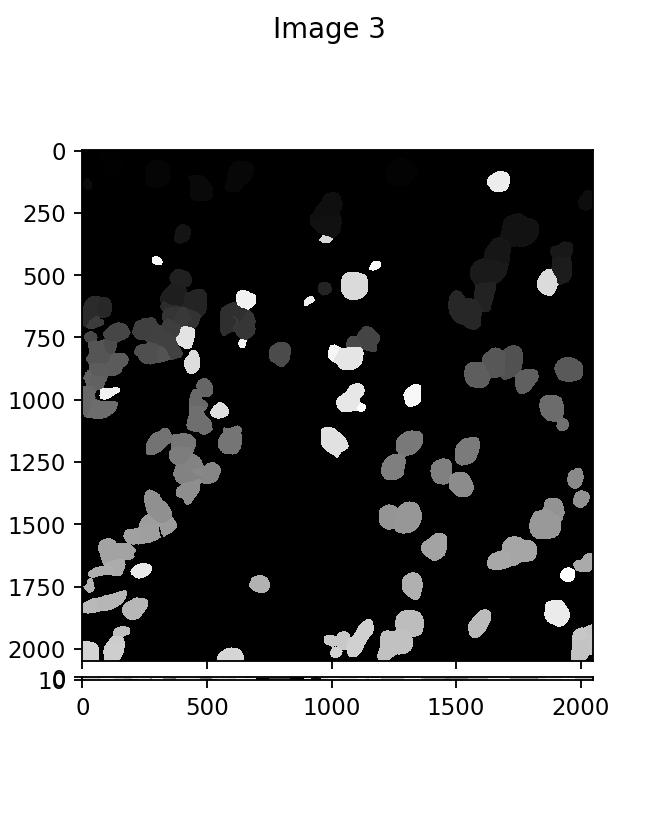

In [24]:
%matplotlib notebook
imshow_mark_3d([polyt_im, dapi_im, corr_labels3d])

# STEP2: Watershed: Optional, potentially make it worse

In [11]:
watershed_th = 1.6

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    #np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    break

- directly load seg from: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy
reference image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
PolyT and DAPI image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H19R1\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
- New save file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488', '405'] in 1.732s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:[

<IPython.core.display.Javascript object>


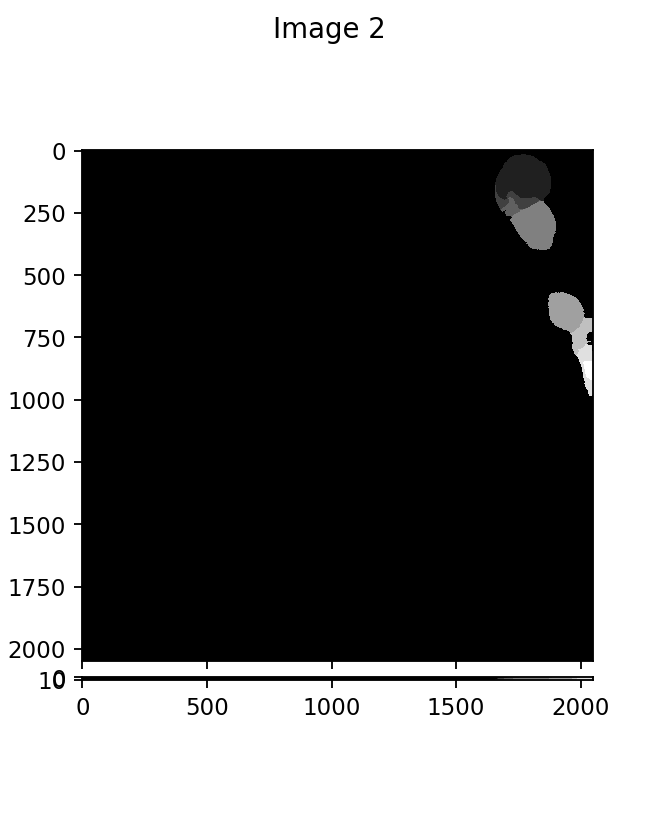

In [203]:
imshow_mark_3d([new_labels, corr_labels3d])

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')